## Spectrum Matching according to the spectrophotometric  colors 

### Load the filter information (SWIFT_UVOT)

In [1]:
from pyphot import Filter
import numpy as np
import matplotlib.pyplot as plt



In [10]:

##  filter functions
### B band
Bdata = open('../filters/B_P08.txt','r')
for line in Bdata:
    lines = np.genfromtxt(Bdata,dtype = [('wavelength',float),('area',float)],comments='#',usecols=(0,1),unpack = True)
lamb_B = lines[0]
B = lines[1]
### V band 
Vdata = open('../filters/V_P08.txt','r')
for line in Vdata:
    lines = np.genfromtxt(Vdata,dtype = [('wavelength',float),('area',float)],usecols=(0,1),unpack = True)
lamb_V = lines[0]
V = lines[1]
###  U band
Udata = open('../filters/U_P08.txt','r')
for line in Udata:
    lines = np.genfromtxt(Udata,dtype = [('wavelength',float),('area',float)],usecols=(0,1),unpack = True)
lamb_U = lines[0]
U = lines[1]
### UVM2
UVM2data = open('../filters/UVM2_B11.txt','r')
for line in UVM2data:
    lines = np.genfromtxt(UVM2data,dtype = [('wavelength',float),('area',float)],usecols=(0,1),unpack = True)
lamb_UVM2 = lines[0]
UVM2 = lines[1]
### UVW2
UVW2data = open('../filters/UVW2_B11.txt','r')
for line in UVW2data:
    lines = np.genfromtxt(UVW2data,dtype = [('wavelength',float),('area',float)],usecols=(0,1),unpack = True)
lamb_UVW2 = lines[0]
UVW2 = lines[1]
###UVW1
UVW1data = open('../filters/UVW1_B11.txt','r')
for line in UVW1data:
    lines = np.genfromtxt(UVW1data,dtype = [('wavelength',float),('area',float)],usecols=(0,1),unpack = True)
lamb_UVW1 = lines[0]
UVW1 = lines[1]

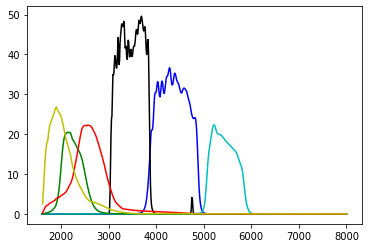

In [11]:
## SWIFT_UVOT_Filter
SWIFT_UVOT_B = Filter(lamb_B,B,name = 'SWFT_UVOT_B',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_U = Filter(lamb_U,U,name = 'SWFT_UVOT_U',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_V = Filter(lamb_V,V,name = 'SWFT_UVOT_V',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_UVM2 = Filter(lamb_UVM2, UVM2,name = 'SWFT_UVOT_UVM2',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_UVW1 = Filter(lamb_UVW1,UVW1,name = 'SWFT_UVOT_UVW1',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_UVW2 = Filter(lamb_UVW2,UVW2,name = 'SWFT_UVOT_UVW2',dtype = 'photon',unit = 'Angstrom')
FilterVec = [SWIFT_UVOT_B,SWIFT_UVOT_U,SWIFT_UVOT_V,SWIFT_UVOT_UVM2,SWIFT_UVOT_UVW1,SWIFT_UVOT_UVW2]
plt.plot(lamb_B,B,'b-', lamb_U,U,'k-',lamb_V,V,'c-',lamb_UVM2,UVM2,'g-',lamb_UVW1,UVW1,'r-',lamb_UVW2,UVW2,'y-')

### Some functions

* Filter Function: FilterFunction(Wavelength, Flux, FilterName). 
* Dust Reddening Law: Reddening(Wavelength, Flux, EB_V, Flux). 

In [12]:
## Filter Function
## Input: Spectrum: wavelength sequence; magnitude sequence; and filter name
## filter name includes: SWIFT_UVOT_B,SWIFT_UVOT_U,SWIFT_UVOT_V,SWIFT_UVOT_UVM2,SWIFT_UVOT_UVW1,SWIFT_UVOT_UVW2
def FilterFunction(Wavelength, Flux, FilterName):
    flux = FilterName.get_flux(Wavelength,Flux)
    return -2.5*np.log10(flux) - FilterName.Vega_zero_mag

In [13]:
## Dust Reddening Law
## Cardelli, Clayton & Mathis (1989) extinction function
import extinction
def Reddening(Wavelength,Flux,EB_V,RV):
    return extinction.apply(extinction.ccm89(Wavelength,RV*EB_V,RV),Flux)
   

* Interpolate the function $S_{\lambda}(x)$

In [15]:
## Spectrum model: Spectrum =  Template + S_lambda(deltaM(15)-1.1)*10^Alambda(E(B-V)RV)
## Only consider the maximum light at this moment
## The uvmodel is from Foley et al. 2016 and gives a modification to a mean spectrum as a function of dm15(B)
SlambdaData = open('uvmodel.data','r')
lines = np.genfromtxt(SlambdaData,dtype = [('wavelength',float),('f_11',float),('Slambda',float)])
SlambdaWave = lines['wavelength']
Slambda = lines['Slambda']
f_11 = lines['f_11']
from scipy.interpolate import interp1d
f11Fun = interp1d(SlambdaWave,f_11,kind = 'cubic')
SlambdaFun = interp1d(SlambdaWave,Slambda ,kind = 'cubic')

* Interpolate the template function (spectra sequences of SN2011fe)

In [17]:
## Template spectrum (at maximum)
### Read one text spectrum (SN2011fe maximum light)
data = open('ptf11kly_20110903.obs.dat','r')
lines = np.genfromtxt(data,dtype = [('wavelength',float),('flux',float),('fluxerr',float)],
                                            usecols=(0,1,2),unpack = True)
# Store wavelength, magnitude and error in arrays to make plot easier
TemplateFlux_ = lines[1]
TemplateLamb_ = lines[0]  
TemplateLamb = TemplateLamb_[(TemplateLamb_>=np.min(SlambdaWave))& (TemplateLamb_<=np.max(SlambdaWave))]
TemplateFlux = TemplateFlux_[(TemplateLamb_>=np.min(SlambdaWave))& (TemplateLamb_<=np.max(SlambdaWave))]

In [19]:
# One toy example to see whether this method works or not 
#---------------------------------
# Based on the known magnitude, we want to estimate three parameters using least square
from pyspeckit import mpfit

FilterVec = [SWIFT_UVOT_B,SWIFT_UVOT_U,SWIFT_UVOT_V,SWIFT_UVOT_UVM2,SWIFT_UVOT_UVW1,SWIFT_UVOT_UVW2]
def peval(x, p):
       # The model function with parameters p
       SpectrumFlux = f11Fun(x) + SlambdaFun(x)*(p[0]-1.1)
       ReddenSpectrumFlux = Reddening(x,SpectrumFlux,p[1],p[2])
       mag0 = np.zeros(6)
       col0 = np.zeros(5)
       for i in range(6):
           mag0[i] = FilterFunction(SlambdaWave,ReddenSpectrumFlux,FilterVec[i])
       col0 = [mag0[5]-mag0[2],mag0[3]-mag0[2],mag0[4]-mag0[2],mag0[1]-mag0[2],mag0[0]-mag0[2]]
       return(col0)
def myfunct(p, fjac=None, x=None, y=None, err=None ):
       # Function that return the weighted deviates
       model = peval(x, p)
       status = 0
       return([status, (y-model)/err])

To test whether the least squares fit can recover three parameters $\Delta M_{15}(B), E(B-V), Rv$, we show a toy example below. 
* The three real parameters are [1.2,0.2,1.8].
* Five spectroscopic colors are [w2, m2,w1,u,b] - v = [3.55, 4.97,1.83,0.13,0.32]
* We add some disturbance to five spectroscopic colors, and asign some uncertainties towarys them. 
* The esimation for three parameters are [1.01 (0.08), 0.21 (0.03), 1.74 (1.21)].

In [21]:
# Generate model data for a Gaussian with param mu and sigma and add noise
import warnings
warnings.filterwarnings('once')
x= SlambdaWave
preal=[1,0.22,2]
y_true=peval(x,preal)
mu,sigma=0,1
y      = y_true + 0.01 * np.random.normal(mu,sigma, len(y_true))
err    = 0.1 * np.random.normal(mu,sigma, len(y_true) )
# Initial estimates for MPFIT
p0 = [1.2, 0.2,1.8]
fa = {'x':x, 'y':y, 'err':err}

# Call MPFIT with user defined function 'myfunct'
m = mpfit.mpfit(myfunct, p0, functkw=fa )

print("status: ", m.status)
if (m.status <= 0): 
   print('error message = ', m.errmsg)
else:
   print("Iterations: ", m.niter)
   print("Fitted pars: ", m.params)
   print("Uncertainties: ", m.perror )

Iter       1    CHI-SQUARE =  10.75592403  DOF =  2
   P0 = 1.2  
   P1 = 0.2  
   P2 = 1.8  
Iter       2    CHI-SQUARE =  0.0919481496  DOF =  2
   P0 = 1.016199589  
   P1 = 0.2037783168  
   P2 = 1.146697875  
Iter       3    CHI-SQUARE =  0.07121618002  DOF =  2
   P0 = 1.032098649  
   P1 = 0.1994245137  
   P2 = 0.8422996542  
Iter       4    CHI-SQUARE =  0.0710521267  DOF =  2
   P0 = 1.032167715  
   P1 = 0.1994377525  
   P2 = 0.8369461984  
Iter       5    CHI-SQUARE =  0.07105212631  DOF =  2
   P0 = 1.032169244  
   P1 = 0.1994377738  
   P2 = 0.8369498498  
status:  1
Iterations:  5
Fitted pars:  [1.03216924 0.19943777 0.83694985]
Uncertainties:  [0.14989399 0.0319309  2.20920646]


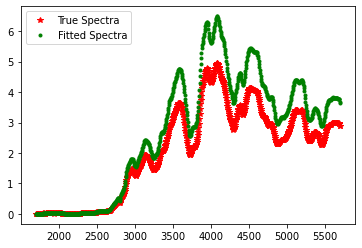

In [22]:
p = preal
SpectrumFlux = f11Fun(x) + SlambdaFun(x)*(p[0]-1.1)
#plt.plot(x,SpectrumFlux,'k-')
ReddenSpectrumFlux = Reddening(x,SpectrumFlux,p[1],p[2])
FittedSpectrum = Reddening(x, f11Fun(x) + SlambdaFun(x)*(m.params[0]-1.1), m.params[1],m.params[2])
plt.plot(x,ReddenSpectrumFlux,'r*',label = "True Spectra")
plt.plot(x,FittedSpectrum,'g.', label = "Fitted Spectra")
plt.legend(loc="upper left")

In [23]:
import warnings
warnings.filterwarnings('ignore')
y_true=peval(x,preal)

In [24]:
SpectrumFlux = f11Fun(x) + SlambdaFun(x)*(p[0]-1.1)
ReddenSpectrumFlux = Reddening(x,SpectrumFlux,p[1],p[2])
#FilterFunction(x, ReddenSpectrumFlux, SWIFT_UVOT_B)
import warnings  
warnings.filterwarnings('once')
SWIFT_UVOT_B.get_flux(x,ReddenSpectrumFlux)

3.6729253517202336